In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import OneHotEncoder,LabelEncoder,TargetEncoder,OrdinalEncoder,StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.ensemble import RandomForestClassifier

from catboost import CatBoostClassifier

download dataset test and train data, put into your local directory -> https://www.kaggle.com/competitions/playground-series-s4e7/data

In [2]:
df = pd.read_csv("train.csv")

In [3]:
df.drop("id", axis=1, inplace=True)

sample_size_class0 = 600000
sample_size_class1 = 600000

class_0 = df[df['Response'] == 0]
class_1 = df[df['Response'] == 1]

sampled_class_0 = class_0.sample(n=sample_size_class0, random_state=42)
sampled_class_1 = class_1.sample(n=sample_size_class1, random_state=42)

df = pd.concat([sampled_class_0, sampled_class_1]).reset_index(drop=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1200000 entries, 0 to 1199999
Data columns (total 11 columns):
 #   Column                Non-Null Count    Dtype  
---  ------                --------------    -----  
 0   Gender                1200000 non-null  object 
 1   Age                   1200000 non-null  int64  
 2   Driving_License       1200000 non-null  int64  
 3   Region_Code           1200000 non-null  float64
 4   Previously_Insured    1200000 non-null  int64  
 5   Vehicle_Age           1200000 non-null  object 
 6   Vehicle_Damage        1200000 non-null  object 
 7   Annual_Premium        1200000 non-null  float64
 8   Policy_Sales_Channel  1200000 non-null  float64
 9   Vintage               1200000 non-null  int64  
 10  Response              1200000 non-null  int64  
dtypes: float64(3), int64(5), object(3)
memory usage: 100.7+ MB


In [4]:
def feature_engineering(dataframe: pd.DataFrame) -> pd.DataFrame:
    df = dataframe.copy(deep=True)
    df.drop(['Gender','Driving_License'], axis=1, inplace=True)
    
    numerical = df.select_dtypes(include='number')
    categorical = df.select_dtypes(['object'])
    categorical_columns = categorical.columns.tolist()

    oneHotEncoder = OneHotEncoder(sparse_output=False)
    ordinalEncoder = OrdinalEncoder(categories=[['< 1 Year', '1-2 Year', '> 2 Years']])
    
    encodedData = oneHotEncoder.fit_transform(categorical[['Vehicle_Damage']])
    encodedDf = pd.DataFrame(encodedData, columns=oneHotEncoder.get_feature_names_out(['Vehicle_Damage']))
    categorical = pd.concat([categorical, encodedDf], axis=1)
    
    categorical['Vehicle_Age_Encoded'] = ordinalEncoder.fit_transform(df[['Vehicle_Age']])
    
    categorical.drop(categorical_columns, axis=1, inplace=True)

    df = pd.concat([numerical, categorical], axis=1)
    
    df['Age_Annual_Premium'] = df['Age'] * df['Annual_Premium']
    df['Vehicle_Damage_Annual_Premium'] = df['Vehicle_Damage_Yes'] * df['Annual_Premium']
    df['Vehicle_Damage_Age'] = df['Vehicle_Damage_Yes'] * df['Age']

    region_agg = df.groupby('Region_Code')['Annual_Premium'].agg(['mean', 'std', 'max']).reset_index()
    region_agg.columns = ['Region_Code', 'Region_Premium_Mean', 'Region_Premium_Std', 'Region_Premium_Max']
    df = df.merge(region_agg, on='Region_Code', how='left')

    df['Age_Bin'] = pd.cut(df['Age'], bins=[0, 18, 25, 35, 45, 55, 65, 75, 85, 95, 105], labels=False)
    
    return df

In [5]:
x = feature_engineering(df)
x.head()

,Age,Region_Code,Previously_Insured,Annual_Premium,Policy_Sales_Channel,Vintage,Response,Vehicle_Damage_No,Vehicle_Damage_Yes,Vehicle_Age_Encoded,Age_Annual_Premium,Vehicle_Damage_Annual_Premium,Vehicle_Damage_Age,Region_Premium_Mean,Region_Premium_Std,Region_Premium_Max,Age_Bin
0,45,3.0,1,40255.0,26.0,158,0,1.0,0.0,1.0,1811475.0,0.0,0.0,22018.240069,14523.245528,252141.0,3
1,25,29.0,1,37886.0,152.0,105,0,1.0,0.0,0.0,947150.0,0.0,0.0,27221.180967,16328.469209,366891.0,1
2,48,28.0,0,45362.0,26.0,149,0,0.0,1.0,1.0,2177376.0,45362.0,48.0,40064.334092,15424.617151,540165.0,4
3,48,28.0,1,35124.0,26.0,96,0,1.0,0.0,1.0,1685952.0,0.0,0.0,40064.334092,15424.617151,540165.0,4
4,22,41.0,1,25775.0,152.0,271,0,1.0,0.0,0.0,567050.0,0.0,0.0,29460.797372,14209.237986,339396.0,1


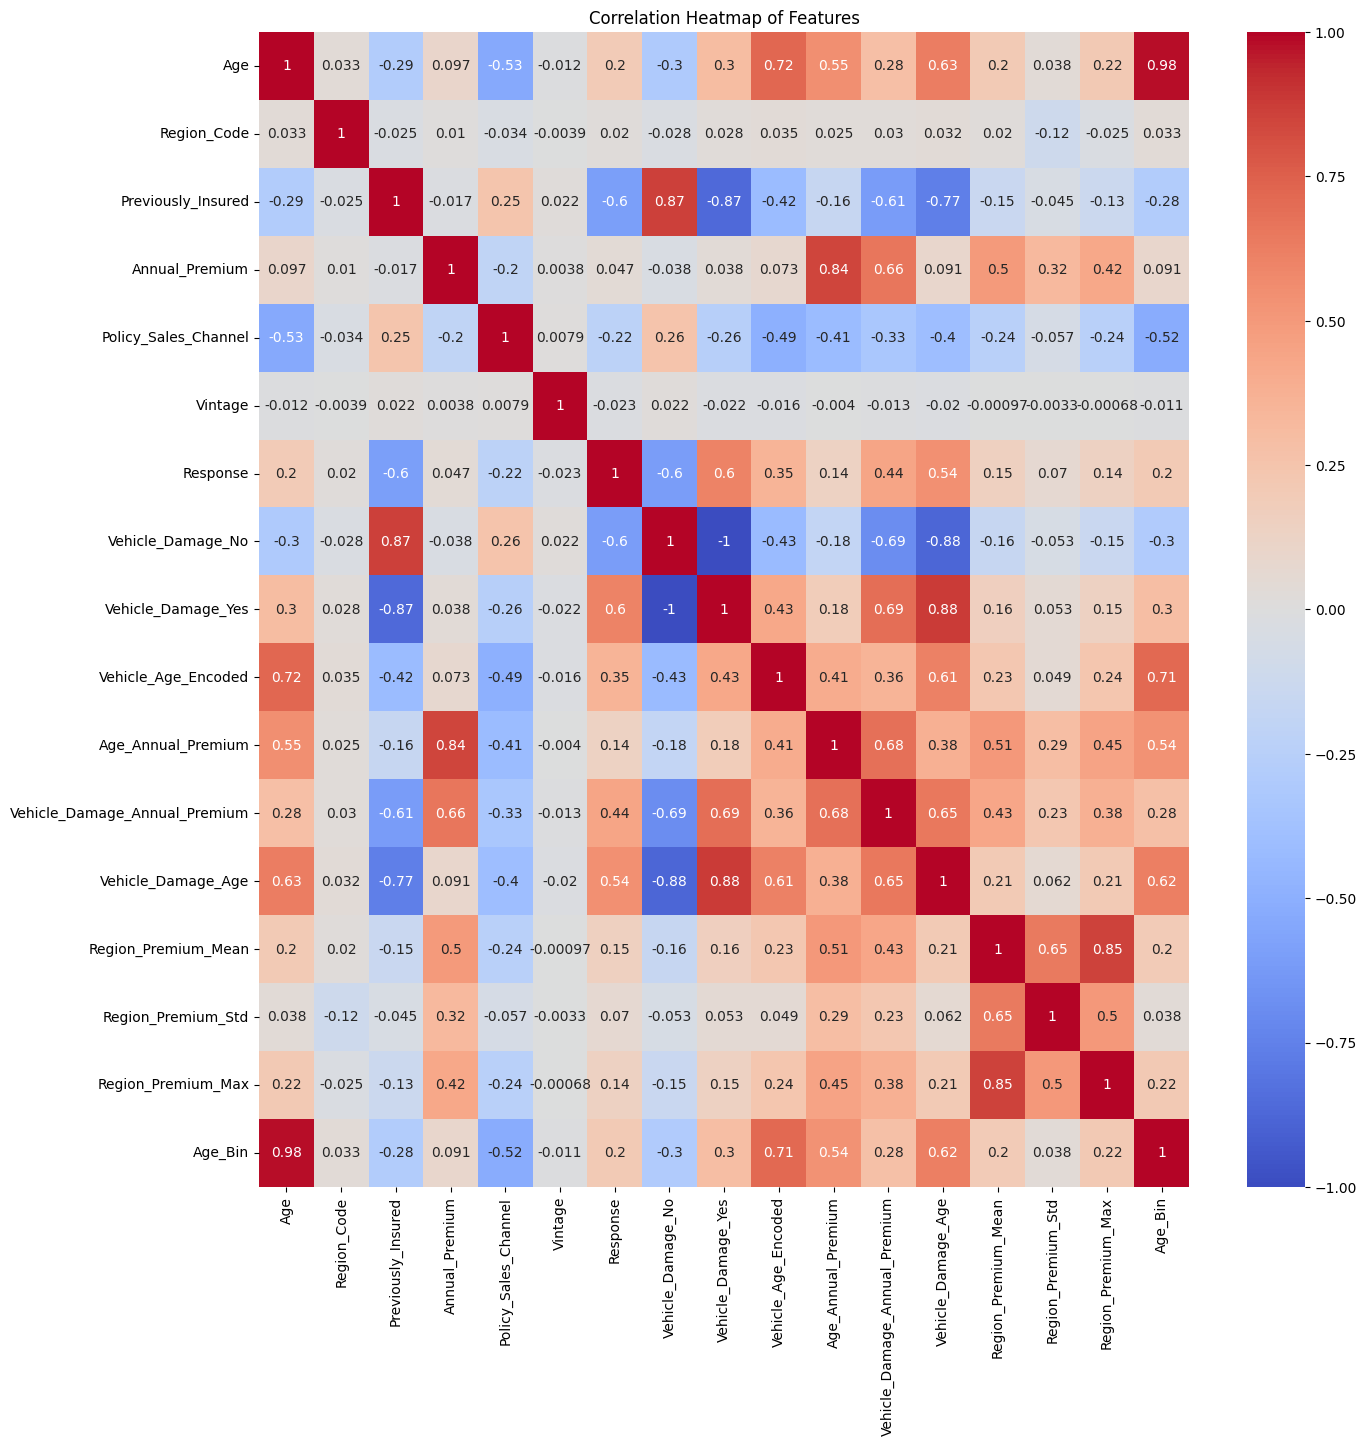

In [6]:
numerical = feature_engineering(df)

corr = numerical.corr()
plt.figure(figsize=(15, 15))
plt.title('Correlation Heatmap of Features')
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.show()

train = df

X = train.drop(["Response"], axis=1)
y = train["Response"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)


model = CatBoostClassifier(
    iterations=2000,
    depth=8,
    learning_rate=0.01,
    cat_features=['Gender','Vehicle_Age','Vehicle_Damage'],
)
model.fit(X_train, y_train)

y_prediction = model.predict(X_test)
score = accuracy_score(y_test, y_prediction)
roc_auc = roc_auc_score(y_test, y_prediction)
roc_auc

In [7]:
train = feature_engineering(df)

X = train.drop(["Response"], axis=1)
y = train["Response"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [8]:
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.fit_transform(X_test)

In [9]:
model = RandomForestClassifier(n_estimators=150 ,random_state=0)
model.fit(X_train_scaled, y_train)

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:  2.9min


RandomForestClassifier(n_estimators=150, random_state=0, verbose=1)

In [10]:
y_prediction = model.predict(X_test_scaled)
score = accuracy_score(y_test, y_prediction)
roc_auc = roc_auc_score(y_test, y_prediction)
roc_auc

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    4.2s


0.7858257929995294

In [11]:
model2 = RandomForestClassifier(n_estimators=150 ,random_state=0)
model2.fit(X_train, y_train)

RandomForestClassifier(n_estimators=150, random_state=0)

In [15]:
y_prediction = model2.predict(X_test)
score = accuracy_score(y_test, y_prediction)
roc_auc = roc_auc_score(y_test, y_prediction)
roc_auc

0.7812407935054604

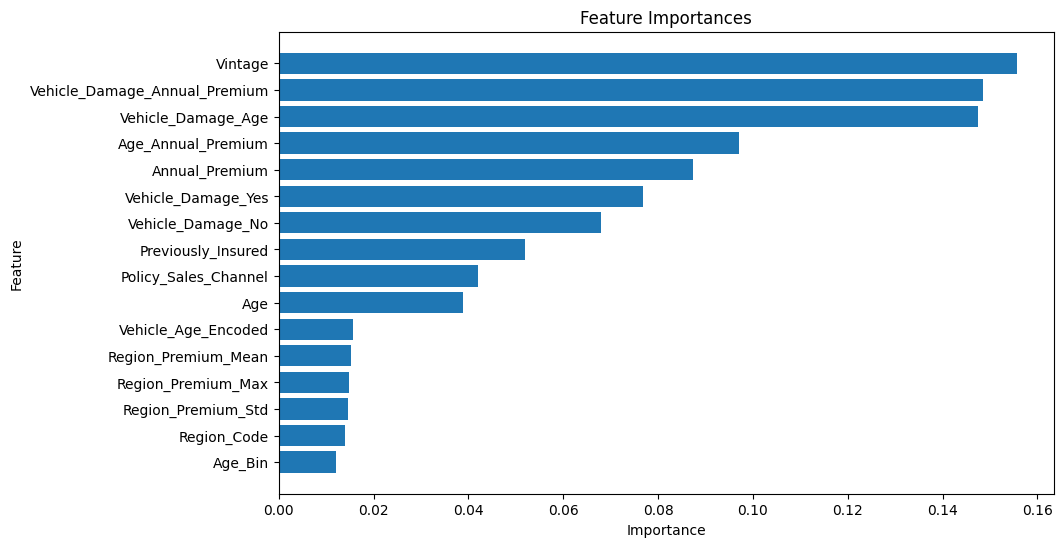

In [13]:
importances = model.feature_importances_

feature_importances = pd.DataFrame({'Feature': X.columns, 'Importance': importances})
feature_importances = feature_importances.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(feature_importances['Feature'], feature_importances['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importances')
plt.gca().invert_yaxis()
plt.show()

In [ ]:
test = pd.read_csv("test.csv")
test_id = test['id']
test.drop("id", axis=1, inplace=True)

#test = feature_engineering(test)
test_prediction = model.predict(test)

test_prediction = pd.DataFrame({"Response": test_prediction})
id_test = pd.DataFrame({"id": test_id})

submission = id_test.join(test_prediction)
submission.to_csv("submission4.csv", index=False)